# Kernel 3.1

the masking that we had try on version3 didn't work, so let's try something new.
In this version will use the same face recog that we used on version3, from that we will spilt image into small square where we will calculate the heartrate seperately and then we will try some thing like majority vote and some other thing.

In [ ]:
import cv2
import numpy as np
import os
import glob

In [5]:
videos = glob.glob('./video_in/*.avi')
print(videos)

['./video_in/HeartRate_2.avi']


In [3]:
#just get the file name nothing less nothing more
filename_ext = os.path.basename(videos[0])
filename, file_extension  = os.path.splitext(filename_ext)
print(filename)

HeartRate_2


In [6]:
# here's the main working pipeline
# we going to read out the video frame by frame
# then using our face landmark detection to marking the frame and write it out another video

# get video handle
video = videos[0]
cap_in = cv2.VideoCapture(video)
try:
    # Find OpenCV version
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
    if int(major_ver)  < 3 :
        fps = cap_in.get(cv2.cv.CV_CAP_PROP_FPS)
        total = int(cap_in.get(cv2.cv.CAP_PROP_FRAME_COUNT))
        print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
    else :
        fps = cap_in.get(cv2.CAP_PROP_FPS)
        total = int(cap_in.get(cv2.CAP_PROP_FRAME_COUNT))
        print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
except:
    cap_in.release()
    cv2.destroyAllWindows()
    
print("the total number of frames in this video is: {0}".format(total))

Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.00003000003
the total number of frames in this video is: 654


In [7]:
duration = total/fps
print("total video length in second is: {0}".format(duration))

total video length in second is: 21.799978199999998


In [8]:
ret, frame = cap_in.read()

In [9]:
import matplotlib.pyplot as plt
rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(40,10))
plt.imshow(rgb_img)
plt.show()

<Figure size 4000x1000 with 1 Axes>

## Draw ROI

In [12]:
from PIL import Image, ImageDraw
import face_recognition

In [38]:
# here the part to develop the pipeline of the filer
rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
face_landmarks_list = face_recognition.face_landmarks(rgb_img)
print("I found {} face(s) in this photograph.".format(len(face_landmarks_list)))

# working with only the first face
face_landmarks = face_landmarks_list[0]  

I found 1 face(s) in this photograph.


In [14]:
print(face_landmarks.keys())
print(face_landmarks['chin'])

dict_keys(['bottom_lip', 'right_eyebrow', 'nose_tip', 'left_eye', 'chin', 'right_eye', 'left_eyebrow', 'nose_bridge', 'top_lip'])
[(249, 158), (249, 178), (251, 197), (255, 216), (264, 233), (276, 248), (291, 259), (307, 266), (324, 267), (339, 263), (350, 254), (359, 242), (367, 228), (371, 214), (374, 198), (376, 182), (376, 166)]


In [37]:
# def roi_draw(img_in, x,y,w,h):
#     roi_draw_img = img_in
#     cv2.rectangle(roi_draw_img,(x,y),(x+w,y+h),(0,0,255),2)
#     return roi_draw_img
def roi_draw(img_in, x1,y1,x2,y2):
    roi_draw_img = np.array(img_in, copy=True)  
#     roi_draw_img = img_in
    cv2.rectangle(roi_draw_img,(x1,y1),(x2,y2),(0,0,255),2)
    return roi_draw_img

In [33]:
y_dis = y2 - y1
print(y_dis,y2,y1)

109 267 158


In [36]:
type(img_out)

numpy.ndarray

249 158 376 267


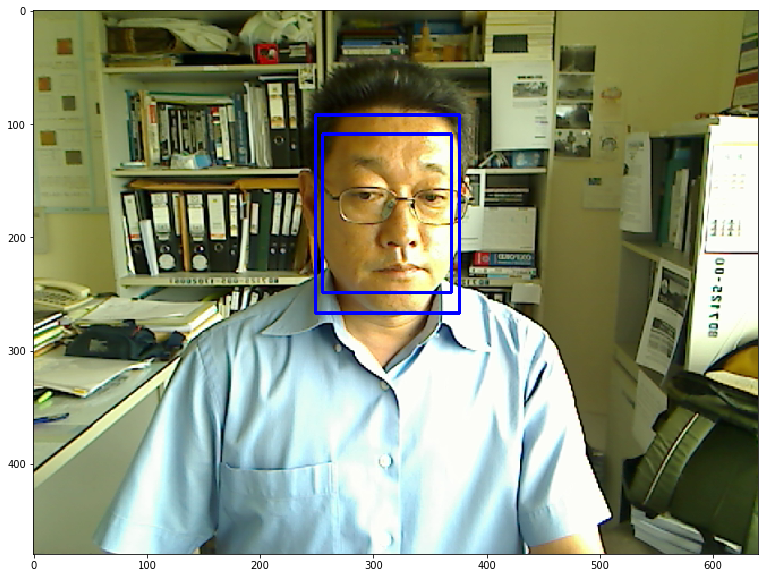

In [62]:
chin_list = face_landmarks['chin']
x1 = chin_list[0][0]
y1 = chin_list[0][1]
x2 = chin_list[len(chin_list)-1][0]
y2 = chin_list[int((len(chin_list)-1)/2)][1]
print(x1,y1,x2,y2)
# img_out = roi_draw(rgb_img,x1,y1,x2,y2)
y_dis = y2 - y1
y0 = int(y1 - 0.6*y_dis)
img_out = roi_draw(rgb_img,x1,y0,x2,y2)
dist_x = x2 - x1
dist_y = y2 - y0
img_out = roi_draw(img_out,int(x1 + 0.1*dist_x/2), int(y0 + 0.2*dist_y/2) , int(x2 - 0.1*dist_x/2), int(y2 - 0.2*dist_y/2) )
# img_out = rgb_img
plt.figure(figsize=(40,10))
plt.imshow(img_out)
plt.show()

# print(chin_list[7],chin_list[8],chin_list[9])
# print(x1)

In [17]:
dist_x = x2 - x1
dist_y = y2 - y0
print(dist_x, dist_y)

127 175


In [18]:
cap_in.release()
cv2.destroyAllWindows()
    

## Roi Size verification
let's verify if this roi draw size will be rigid for the whole video

In [43]:
from PIL import Image, ImageDraw
import face_recognition

def find_roi(img_in, prev):
    # here the part to develop the pipeline of the filer
    rgb_img = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
    face_landmarks_list = face_recognition.face_landmarks(rgb_img)
    people_num = len(face_landmarks_list)
    print("I found {} face(s) in this photograph.".format(people_num))
    if people_num == 0:
        if not prev:
            ValueError("no face from the frist frame is not allowed")
        else:
            face_landmarks =  prev
    else:
        # working with only the first face
        face_landmarks = face_landmarks_list[0]  
        
    
    chin_list = face_landmarks['chin']
    x1 = chin_list[0][0]
    y1 = chin_list[0][1]
    x2 = chin_list[len(chin_list)-1][0]
    y2 = chin_list[int((len(chin_list)-1)/2)][1]
    # img_out = roi_draw(rgb_img,x1,y1,x2,y2)
    y_dis = y2 - y1
    y0 = int(y1 - 0.6*y_dis)
    dist_x = x2 - x1
    dist_y = y2 - y0
    print(dist_x, dist_y)
    return [dist_x,dist_y],face_landmarks

    

In [44]:
# here's the main working pipeline
# we going to read out the video frame by frame
# then using our face landmark detection to marking the frame and write it out another video

# get video handle
video = videos[0]
cap_in = cv2.VideoCapture(video)
try:
    # Find OpenCV version
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
    if int(major_ver)  < 3 :
        fps = cap_in.get(cv2.cv.CV_CAP_PROP_FPS)
        total = int(cap_in.get(cv2.cv.CAP_PROP_FRAME_COUNT))
        print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
    else :
        fps = cap_in.get(cv2.CAP_PROP_FPS)
        total = int(cap_in.get(cv2.CAP_PROP_FRAME_COUNT))
        print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
except:
    cap_in.release()
    cv2.destroyAllWindows()
    
print("the total number of frames in this video is: {0}".format(total))

Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.00003000003
the total number of frames in this video is: 654


In [45]:
count = 0
max_x = -1
min_x = 10000
tot_x = 0
max_y = -1
min_y = 10000
tot_y = 0
prev = []
while(True):
    ret, frame = cap_in.read()
    if not ret:
        print(ret)
        break
    temp, prev = find_roi(frame,prev)
    tot_x = tot_x + temp[0]
    if(temp[0]>max_x):
        max_x = temp[0]
    elif(temp[0]<min_x):
        min_x = temp[0]
    tot_y = tot_y + temp[1]
    if(temp[1]>max_y):
        max_x = temp[0]
    elif(temp[1]<min_y):
        min_x = temp[0]
    count = count +1

cap_in.release()
cv2.destroyAllWindows()
print('done')
avg = tot/count
print(avg)

I found 1 face(s) in this photograph.
127 175
I found 1 face(s) in this photograph.
129 176
I found 1 face(s) in this photograph.
130 176
I found 1 face(s) in this photograph.
126 170
I found 1 face(s) in this photograph.
128 172
I found 1 face(s) in this photograph.
129 173
I found 1 face(s) in this photograph.
128 172
I found 1 face(s) in this photograph.
126 173
I found 1 face(s) in this photograph.
126 164
I found 1 face(s) in this photograph.
127 176
I found 1 face(s) in this photograph.
127 173
I found 1 face(s) in this photograph.
126 173
I found 1 face(s) in this photograph.
127 167
I found 1 face(s) in this photograph.
128 173
I found 1 face(s) in this photograph.
129 173
I found 1 face(s) in this photograph.
126 172
I found 1 face(s) in this photograph.
125 164
I found 1 face(s) in this photograph.
127 170
I found 1 face(s) in this photograph.
125 164
I found 1 face(s) in this photograph.
127 173
I found 1 face(s) in this photograph.
127 170
I found 1 face(s) in this photogra

I found 1 face(s) in this photograph.
129 176
I found 1 face(s) in this photograph.
129 178
I found 0 face(s) in this photograph.
129 178
I found 1 face(s) in this photograph.
125 168
I found 1 face(s) in this photograph.
126 180
I found 0 face(s) in this photograph.
126 180
I found 0 face(s) in this photograph.
126 180
I found 0 face(s) in this photograph.
126 180
I found 0 face(s) in this photograph.
126 180
I found 0 face(s) in this photograph.
126 180
I found 0 face(s) in this photograph.
126 180
I found 1 face(s) in this photograph.
129 178
I found 0 face(s) in this photograph.
129 178
I found 0 face(s) in this photograph.
129 178
I found 0 face(s) in this photograph.
129 178
I found 0 face(s) in this photograph.
129 178
I found 0 face(s) in this photograph.
129 178
I found 0 face(s) in this photograph.
129 178
I found 0 face(s) in this photograph.
129 178
I found 0 face(s) in this photograph.
129 178
I found 0 face(s) in this photograph.
129 178
I found 1 face(s) in this photogra

I found 1 face(s) in this photograph.
128 168
I found 1 face(s) in this photograph.
126 167
I found 1 face(s) in this photograph.
127 164
I found 1 face(s) in this photograph.
126 164
I found 1 face(s) in this photograph.
128 170
I found 1 face(s) in this photograph.
125 157
I found 1 face(s) in this photograph.
127 172
I found 0 face(s) in this photograph.
127 172
I found 1 face(s) in this photograph.
119 160
I found 0 face(s) in this photograph.
119 160
I found 0 face(s) in this photograph.
119 160
I found 1 face(s) in this photograph.
124 154
I found 1 face(s) in this photograph.
128 167
I found 0 face(s) in this photograph.
128 167
I found 1 face(s) in this photograph.
128 168
I found 1 face(s) in this photograph.
124 162
I found 1 face(s) in this photograph.
123 164
I found 1 face(s) in this photograph.
121 164
I found 1 face(s) in this photograph.
121 162
I found 1 face(s) in this photograph.
125 167
I found 1 face(s) in this photograph.
124 167
I found 1 face(s) in this photogra

I found 1 face(s) in this photograph.
128 175
I found 1 face(s) in this photograph.
127 168
I found 1 face(s) in this photograph.
128 170
I found 1 face(s) in this photograph.
127 172
I found 1 face(s) in this photograph.
127 168
I found 1 face(s) in this photograph.
130 172
I found 1 face(s) in this photograph.
127 173
I found 1 face(s) in this photograph.
127 170
I found 1 face(s) in this photograph.
128 172
I found 1 face(s) in this photograph.
127 172
I found 1 face(s) in this photograph.
124 167
I found 1 face(s) in this photograph.
122 157
I found 1 face(s) in this photograph.
125 170
I found 1 face(s) in this photograph.
121 159
I found 1 face(s) in this photograph.
126 170
I found 1 face(s) in this photograph.
124 164
I found 1 face(s) in this photograph.
125 168
I found 1 face(s) in this photograph.
126 165
I found 1 face(s) in this photograph.
125 165
I found 1 face(s) in this photograph.
128 168
I found 1 face(s) in this photograph.
126 168
I found 1 face(s) in this photogra

NameError: name 'vid' is not defined

In [49]:
avg_x = tot_x/count
avg_y = tot_y/count
print(avg_x, min_x,max_x)
print(avg_y, min_y,max_y)

125.78373983739837 34 126
167.39837398373984 10000 -1


In [27]:
print(tot)

[0, 0, 127, 175, 129, 176, 130, 176, 126, 170, 128, 172, 129, 173, 128, 172, 126, 173, 126, 164, 127, 176, 127, 173, 126, 173, 127, 167, 128, 173, 129, 173, 126, 172, 125, 164, 127, 170, 125, 164, 127, 173, 127, 170, 127, 173, 126, 167, 127, 167, 126, 164, 126, 159, 129, 168, 128, 175, 129, 180]


In [35]:
prev =[]
if not prev:
    print("empty")
else:
    print("yi")

empty


In [37]:
ValueError("Arrays must have the same size").
print(a)

SyntaxError: invalid syntax (<ipython-input-37-2091340d99b0>, line 1)

In [53]:
x_num = 129/5
y_num = 175/5
print(x_num,y_num)
print(int(x_num),int(y_num))


25.8 35.0
25 35


In [ ]:
x_num = 127/5
y_num = 175/5